<center>
<font color="orange">
<h2 style="font-family: 'Times New Roman', sans-serif;">Collaborative Filtering Implementations of a Restaurant Recommendation System </h2>
</font>
</center>
<center>
<font color="orange">
<h4 style="font-family: 'Times New Roman', sans-serif;"> by Njeri Mwenjwa</h4>
</font>
</center>


# **Table of Contents**

**1. [Introduction](#introduction)**<br>
**2. [Data Collection](#data-collection)**<br>
**3. [Data Processing](#data-processing)**<br>
**4. [Restaurant Recommendation Systems](#restaurant-recommendation-systems)**<br>
   - **a. [User-Based Recommendation System](#user-based-recommendation-system)**<br>
   - **b. [Item-Based Recommendation System](#item-based-recommendation-system)**<br>
   - **c. [Model-Based Recommendation System](#model-based-recommendation-system)**<br>
   
**5. [Comparative Analysis of the Implemented Systems](#comparative-analysis-of-the-implemented-systems)** <br>
**6. [Executive Summary](#executive-summary)**<br>


## **Introduction**<a name="introduction"></a>


Building on my implementation of a Content-Based Recommendation system, I will now implement a Collaborative Filter Restaurant Recommendation system.

A collaborative filtering (CF) recommendation system is a type of recommendation system that makes predictions about a user's preferences for products or services by leveraging the preferences and behaviors of a group of users. The underlying idea is that if a user A has similar preferences to user B on certain items, then A is likely to have similar preferences to B on other items as well. Collaborative filtering methods are based on the principle of "users like you also liked" or "users who liked this also liked."

There are two main types of collaborative filtering:
- Memory-Based CF
- Model Based CF

### **Memory-Based Collaborative Filtering:**
Memory-based collaborative filtering methods make recommendations based on the similarities between users or items. There are two main types of memory-based CF:<br><br>

**1. User-Based Collaborative Filtering:**

In user-based collaborative filtering, recommendations are made based on the preferences of users who are similar to the target user.
The system identifies users with similar patterns of item preferences to the target user.
If user A and user B have liked or interacted with similar items, and user A has liked an item that user B hasn't seen yet, the system may recommend that item to user B.
This method is effective for capturing user preferences and discovering items that are popular among users with similar tastes.<br>

**2. Item-Based Collaborative Filtering:**

In item-based collaborative filtering, recommendations are made based on the similarity between items rather than users.
The system identifies items that are similar to the ones the user has liked or interacted with.
If a user has shown interest in item X, and item Y is similar to item X, the system may recommend item Y to the user.
This method is effective for suggesting items that are similar in content or characteristics to the ones the user has already shown interest in.<br>


### **Model-Based Collaborative Filtering:**
Model-based collaborative filtering methods use machine learning models to make predictions. Unlike memory-based collaborative filtering, which directly uses observed user-item interactions, model-based collaborative filtering builds a predictive model based on the available data.

Dimensionality reduction plays a crucial role in model-based collaborative filtering for several reasons. One primary motivation is to handle the sparsity inherent in recommendation datasets. In a typical recommendation system, users only interact with a small fraction of the available items, leading to a sparse user-item matrix. This sparsity can make it challenging to discover meaningful patterns and relationships between users and items. Dimensionality reduction involves capturing the most relevant information in a lower-dimensional space, allowing the system to focus on the essential features and discard noise, making the underlying patterns more discernible. Doing this also helps improve performance of the recommendation algorithm.

Singular Value Decomposition (SVD) is a mathematical technique used for dimensionality reduction in the context of collaborative filtering. SVD decomposes the original user-item interaction matrix into three matrices: the user matrix (U), the item matrix (V), and a diagonal matrix of singular values (S). These matrices represent latent factors that capture hidden patterns and relationships in the data. The diagonal matrix contains the importance or strength of each latent factor. By selecting the top-k singular values and their corresponding vectors, dimensionality is reduced, leading to a truncated approximation of the original matrix. The reduced matrices, U and V, capture the most critical features and relationships between users and items. More on this will come soon.

We will be looking at an implementation of a user-based CF, an item-based CF and a model-based CF, and making comparisons with the previous assignment's Content-Based recommendation system to determine the supreme restaurant recommendation system.

In [60]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error



## **Data Collection**<a id="data-collection"></a>

Some issues I ran into while collecting and building on my previous dataset are:
1. I have inadequate data on restaurant reviews.
2. It was very difficult to get people to give me their opinions on restaurants they have interacted with because its a very time consuming process and even if they could give me reviews, their number of interactions are a very tiny fraction of the data I will need to build a functional system. The sparsity issue inherent in recommendation datasets came to life.
3. I do not have data engineering systems set up to collect and manage data to the magnitude I need to build a functional recommendation system.

Therefore, I decided to generate data of random individuals and their reviews of restaurants in Buenos Aires, making this recommendation system a proof of concept and non-specific to me or anyone else's preferences.

I made the number of reviews random for every user since in typical systems, engagements of users with items exists in a spectrum; some interact with many items while others are new and may have interacted with relatively fewer items.

In [61]:
"""
MY ORIGINAL DATA
"""
PATH = 'ba_restaurants.csv'

# import data
df = pd.read_csv(PATH)

original_df = df.copy()
content_based_df = df.copy() # for content based filtering for comparison
df.head()

,name,cuisine,rating,no_of_reviews,price_range,user_id,description,place_id,about
0,Elena,South American,4.6,2323.0,4,0,offers dine-in service only and is closed betw...,1.0,"{""Service options"": {""Dine-in"": true, ""Deliver..."
1,Tomo 1,Fine dining,4.6,450.0,4,0,a fine dining restaurant located within the Bu...,2.0,"{""Service options"": {""Outdoor seating"": true, ..."
2,Cabernet,Argentinian,4.2,2486.0,3,0,Intimate fine dining spot offering European fa...,3.0,"{""Service options"": {""Outdoor seating"": true, ..."
3,ALMA BuenosAires,Argentinian,4.5,230.0,0,0,offers dine-in and takeaway service options bu...,4.0,"{""Service options"": {""Outdoor seating"": true, ..."
4,Santos Manjares,Steak house,4.7,4092.0,2,0,"a highly-rated steakhouse in BuenosAires, loca...",5.0,"{""From the business"": {""Identifies as women-ow..."


In [62]:
# Function to generate reviews for each user

def random_choice_except(lst, excluded_items):
    """
    Randomly select an item from a list, excluding a given list of items.

    Args:
        lst (list): The list of items to choose from
        excluded_items (list): The list of items to exclude
    """
    choices = [item for item in lst if item['place_id'] not in excluded_items]
    if not choices:
        raise ValueError("All items are excluded or not in the list.")
    return random.choice(choices)

def generate_user_reviews(user_id, restaurants, num_reviews_per_user):
    """
    Generate a list of reviews for a given user_id

    Args:
        user_id (int): The user_id
        restaurants (list): A list of restaurants
        num_reviews_per_user (int): The number of reviews to generate
    """
    user_reviews = []
    reviewed_places = set()

    for _ in range(num_reviews_per_user):

        chosen_restaurant = random_choice_except(restaurants, reviewed_places)

        chosen_restaurant = random.choice(restaurants)
        
        # Check if the user has already reviewed the chosen restaurant
        # while chosen_restaurant['place_id'] in reviewed_places:
        #     chosen_restaurant = random.choice(restaurants)
            
        review = {
            'user_id': user_id,
            'place_id': chosen_restaurant['place_id'],
            'name': chosen_restaurant['name'],
            'cuisine': chosen_restaurant['cuisine'],
            'rating': random.uniform(1.0, 5.0),
            'no_of_reviews': chosen_restaurant['no_of_reviews'],
            'price_range': chosen_restaurant['price_range'],
            'description': chosen_restaurant['description'],
            'about': chosen_restaurant['about'],
        }

        user_reviews.append(review)
        reviewed_places.add(chosen_restaurant['place_id'])

    return user_reviews

# Set a seed for reproducibility
random.seed(42)
np.random.seed(42)

# Extend user_ids up to 99
num_users = 1000
user_ids = list(range(num_users))

# Create additional rows with user_ids in the range from 0 to 99
additional_rows = []
for user_id in user_ids:
    additional_rows.extend(df[df['user_id'] == 0].replace(0, user_id).to_dict('records'))

# Concatenate the original DataFrame with the additional rows
restaurant_df = pd.concat([df, pd.DataFrame(additional_rows)], ignore_index=True)

# Assign 100 reviews to each user
num_reviews_per_user = random.randint(1,150)
all_user_reviews = []

# Iterate through each user_id
for user_id in user_ids:
    user_group = restaurant_df[restaurant_df['user_id'] == user_id]
    user_reviews = generate_user_reviews(user_id, user_group.to_dict('records'), num_reviews_per_user)
    all_user_reviews.extend(user_reviews)

# Create a new DataFrame with the generated reviews
df = pd.DataFrame(all_user_reviews)

# Drop any duplicate entries
df = df.drop_duplicates(subset=['user_id', 'place_id'])

# Display the resulting DataFrame
print("Shape of the dtafarame is", df.shape)
df.sample(n=20)

Shape of the dtafarame is (26256, 9)


,user_id,place_id,name,cuisine,rating,no_of_reviews,price_range,description,about
21863,753,86.0,Bar Cabildo de BuenosAires,Argentinian,3.342816,4969.0,2,"Bar Cabildo de BuenosAires, celebrated for its...","{""Service options"": {""Outdoor seating"": true, ..."
22197,765,128.0,Kentucky,Pizza,1.208523,4711.0,2,"Kentucky, recognized in BuenosAires, offers a ...","{""Service options"": {""Outdoor seating"": true, ..."
8885,306,110.0,La Tri restaurante ecutoriano,Ecuadorian,4.738702,18.0,306,"La Tri Restaurante Ecuatoriano, recognized in ...","{""Service options"": {""Kerbside pickup"": true, ..."
6640,228,52.0,Brasileirinho,Brazilian,2.524532,470.0,228,"Brasileirinho, a restaurant in BuenosAires, se...","{""Service options"": {""Outdoor seating"": true, ..."
24472,843,83.0,Suiren Sushi,Japanese,4.936381,296.0,2,"Suiren Sushi, though not providing a specific ...","{""Service options"": {""Kerbside pickup"": true, ..."
22381,771,113.0,Café Bar,Cafe,4.242083,6.0,771,"Café Bar, though not providing a specific addr...","{""Service options"": {""Takeaway"": true, ""Dine-i..."
8329,287,59.0,Restaurante Chino Central,Chinese,1.700201,903.0,2,Restaurante Chino Central is recognized in Bue...,"{""Service options"": {""Kerbside pickup"": true, ..."
27738,956,125.0,Lavalle Express Sa,Italian,3.975891,2.0,956,"Lavalle Express Sa, recognized in BuenosAires,...","{""Service options"": {""Takeaway"": true, ""Dine-i..."
11526,397,122.0,Pizzería Banchero,Pizza,1.885644,8103.0,2,"Pizzería Banchero, a well-known pizzeria in Bu...","{""Service options"": {""No-contact delivery"": tr..."
10446,360,88.0,Parrilla Y Tenedor Libre,Chinese,3.984608,42.0,360,"Parrilla Y Tenedor Libre, though not providing...","{""Service options"": {""Takeaway"": true, ""Dine-i..."


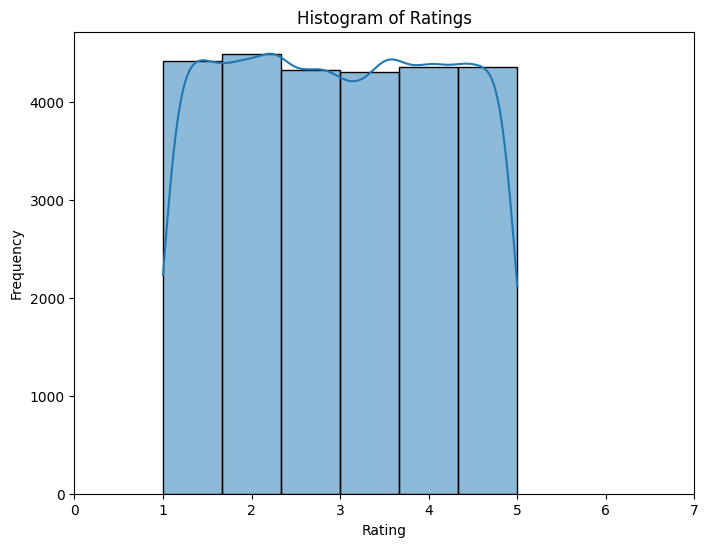

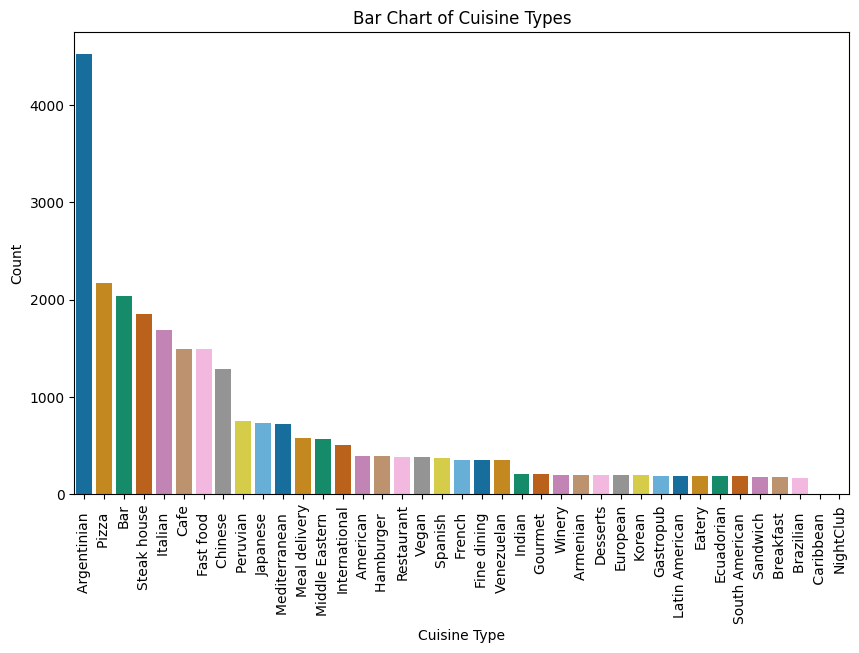

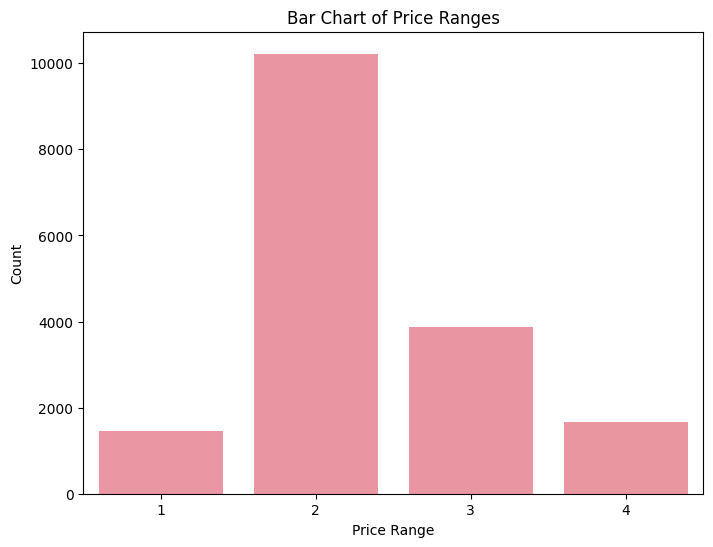

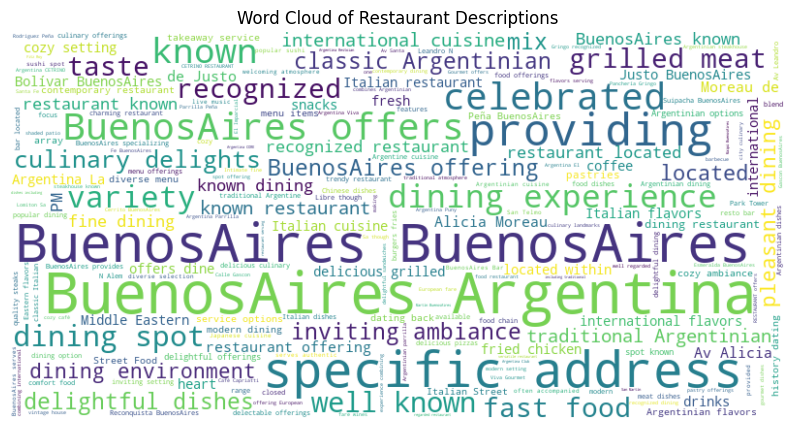

In [63]:
# 1. Histogram of Ratings
plt.figure(figsize=(8, 6))
sns.histplot(df['rating'], bins=6, kde=True, edgecolor='black')
plt.xlim(0,7)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')
plt.show()

# 2. Bar Chart of Cuisine Types
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='cuisine', 
            order=df['cuisine'].value_counts().index, palette="colorblind")
plt.xlabel('Cuisine Type')
plt.ylabel('Count')
plt.title('Bar Chart of Cuisine Types')
plt.xticks(rotation=90)
plt.show()

# 3. Bar Chart of Price Ranges
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='price_range')
plt.xlim(0.5,4.5)
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.title('Bar Chart of Price Ranges')
plt.show()

# 4. Word Cloud of Restaurant Descriptions
text = ' '.join(df['description'].dropna())
wordcloud = WordCloud(width=800, height=400, 
                    background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Restaurant Descriptions')
plt.show()


These are some trends and observations that can be made based on the provided data. 

**Cuisine Types:**
1. Argentinian cuisine appears to be quite popular, with a significant number of restaurants offering this type of cuisine.
2. Italian, Steakhouse, and Japanese cuisines also have a notable presence in the dataset.
3. Some less common cuisines like Caribbean and Vietnamese are represented by only a few restaurants.

**Ratings:**
1. There is a uniform distribution of ratings. This is due to `random.uniform` being used to generate a user's review for each restaurant. `random.uniform `is a function in Python's random module that generates random floating-point numbers uniformly distributed over a specified range. It generates numbers in a way that each value in the specified range has an equal chance of being selected.

**Number of Reviews:**
1. Some restaurants have a substantial number of reviews, indicating they are well-known and frequently visited.
2. However, there are also restaurants with very few or even no reviews. This suggests variations in popularity and possibly new entries in the dataset.

**Price Ranges:**
1. Price ranges vary from 0 (possibly representing low-cost or budget options) to 4 (indicating higher-priced or fine dining establishments).
2. Many restaurants fall in the middle price ranges (2 and 3).

**Missing Values:**
1. There are missing values in the 'description' column for some restaurants.

**Price Range and Ratings:**
1. Price range doesn't always correlate directly with ratings, as there are restaurants with both high and low ratings across different price ranges.


Source: Njeri's CS156 Assignment 1 (the dataset used is the same)

## **Data Processing** <br><a id="data-processing"></a>
An advantage of CF is that this method doesn't require detailed information about the items themselves. It relies only on user-item interactions and doesn't need explicit knowledge of item features. For example, two users can be considered similar if they give the same ratings to ten restaurants despite there being a big difference in their age(or other factors).

# **Restaurant Recommendation Systems**<a id="restaurant-recommendation-systems"></a>


### **Memory-Based Collaborative Filtering**

Memory-based CF methods make recommendations based on the similarities between users or items. 

There are two main types of memory-based CF:<br><br>
**1. User-Based CF**<br>
**2. Item-Based CF**

#### **User-Based CF** <a id="user-based-recommendation-system"></a>

As mentioned, this is a collaborative filtering approach that leverages the preferences and behaviors of similar users to make personalized recommendations for a target user. For a user **U** with a similar set of users determined based on given restaurant ratings, the predicted rating of a restaurant **R** which hasn't been rated yet by user **U** is found by identifying users similar to user **U** who have rated restaurant **R** already and calculating the predicted rating based on those users' ratings of restaurant **R**.

i.e user A,B & C are similar to user D, so user D's predicted rating of restaurant R is based on users' A,B & C's ratings of restaurant R.

Here's a step-by-step explanation of how our user-based CF restaurant recommendation system works:

- The user-restaurant interactions are represented in a DataFrame (`df`), where each row corresponds to a user-restaurant pair, and the 'rating' column contains the user's rating for a particular restaurant.

1. **User-Item Matrix:**
   - The DataFrame is transformed into a user-item matrix (`user_item_matrix`), where rows represent users, columns represent restaurants, and the matrix elements contain the user's ratings for the corresponding restaurants. Missing values are filled with zeros.<br><br>

2. **Similarity Computation with Rating Normalisation:**
   - In recommendation systems, users often employ different rating scales, introducing variability in their rating behaviors. To address this, rating normalization is applied before computing cosine similarity between users.
   - The normalization process involves adjusting each user's ratings by subtracting their average rating. This step helps account for users who consistently rate items higher or lower than others due to personal rating tendencies.
   - The formula for normalizing ratings given by a user is:

      $$
      \text{Normalized Rating}_{i,j} = \text{Rating}_{i,j} - \text{Average Rating}_{i}
      $$

      Where:
      - $\text{Normalized Rating}_{i,j}$ is the normalized rating of user $i$ for item $j$.
      - $\text{Rating}_{i,j}$ is the original rating given by user $i$ for item $j$.
      - $\text{Average Rating}_{i}$ is the average rating given by user $i$ across all items.
   
   - The normalized ratings are then used to calculate the cosine similarity between users, resulting in a user similarity matrix (`user_similarity`), where each entry $(i, j)$ represents the similarity between users $i$ and $j$.
   - The formula used to calculate the cosine of similarity is the following:

      $$
      \text{Cosine Similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \cdot \|\mathbf{B}\|}
      $$
      Where:
      - $\mathbf{A} \text{ and } \mathbf{B}$ are restaurant vectors to be compared.
      - $\cdot$ represents the dot product of the two vectors.
      - $\mathbf{A} \text{ and } \mathbf{B}$ are the Euclidean norms (magnitude) of the vectors $ \mathbf{A} \text{ and } \mathbf{B} $, respectively.

   - This formula calculates the cosine of the angle between two vectors, providing a measure of similarity that ranges from -1 (completely dissimilar) to 1 (completely similar), with 0 indicating no similarity. 

   Reasons for Rating Normalization:
   - Consistent Scale: Normalizing ratings ensures a consistent scale across users, mitigating the impact of users who tend to use higher or lower rating scales than others.
   - Relative Preference: The focus shifts from absolute ratings to relative preferences. Users are compared based on the patterns of their preferences rather than the absolute values they assign.
   - Improved Similarity: Normalization enhances the accuracy of cosine similarity calculations by emphasizing users' relative preferences, making the recommendations more robust and reflective of user taste similarities.
   - Personalization: By normalizing ratings, the recommendation system becomes more adaptive to individual users' rating behaviors, providing personalized recommendations that align with their specific preferences.<br><br>

3. **Prediction:**

   - The `predicted_rating` function takes a user, a restaurant, the user similarity matrix, and the user-item matrix as input. 
   - It calculates the predicted rating for the target user and restaurant using a weighted average formula, considering the similarity scores as weights. - This formula accounts for the fact that users are not equally similar to the target user, so the rating of the most similar user matters more than the second most similar user and so on.

   - The Formula for Predicted Rating of Restaurant $k$ for Target User $i$ is:
      $$
      \text{Predicted Rating}_{i,k} = \frac{\sum_{j} (\text{Similarity}_{i,j} \times \text{Rating}_{j,k})}{\sum_{j} |\text{Similarity}_{i,j}|}
      $$
      Where:
      - $\text{Similarity}_{i,j}$ is the cosine similarity between user $i$ and user $j$.
      - $\text{Rating}_{j,k}$ is the rating of user $j$ for restaurant $k$. 

   - This formula essentially computes a weighted average of ratings for restaurant $k$ by considering the similarity scores as weights. Users who are more similar contribute more to the predicted rating. The denominator ensures normalization by summing the absolute values of similarity scores.

4. **Recommendation:**

   Ratings for items already interacted with by the target user are dropped.
   Finally, the top N items with the highest predicted ratings are recommended to the target user.

In [64]:
# Normalize Ratings
user_avg_ratings = df.groupby('user_id')['rating'].mean()
df['normalized_rating'] = df['rating'] - df['user_id'].map(user_avg_ratings)

In [65]:
def predicted_rating(similarity_matrix, user_item_matrix, user_id, item_id, collaborative_filter='user'):
    """
    Calculate the predicted rating for a target user and item based on the given formula.

    Parameters:
        similarity_matrix (DataFrame): Matrix of cosine similarity scores between users or between items.
        user_item_matrix (DataFrame): Matrix of user-item interactions (ratings).
        user_id (int): Target user ID.
        item_id (int): Target item ID.
        collaborative_filter (str): Type of collaborative filtering ('user' or 'item').

    Returns:
        float: Predicted rating for the target user and item.
    """
    if collaborative_filter == 'user':
        # For user-based collaborative filtering, extract similarity scores for the target user
        similarities = similarity_matrix.iloc[user_id]
        
        # Extract ratings for the target item
        ratings = user_item_matrix.loc[item_id]

    elif collaborative_filter == 'item':
        # For item-based collaborative filtering, extract similarity scores for the target item
        similarities = similarity_matrix.loc[item_id]
        
        # Extract ratings for the target user
        ratings = user_item_matrix.loc[user_id]

    else:
        raise ValueError("Collaborative filter type must be 'user' or 'item'.")

    # Calculate the numerator of the formula
    numerator = np.sum(similarities * ratings)

    # Calculate the denominator of the formula
    denominator = np.sum(np.abs(similarities))

    # Avoid division by zero
    if denominator == 0:
        return 0

    # Calculate the predicted rating
    predicted_rating = numerator / denominator

    return predicted_rating

In [66]:
# Function to get top N recommendations for a user
def user_based_recommend_items(user_similarity_matrix, user_item_matrix, user_id, num_recommendations):
    """
    Generate top N recommendations for a given user based on user-based collaborative filtering.
    
    Parameters:
        user_similarity_matrix (DataFrame): Matrix of cosine similarity scores between users.
        user_item_matrix (DataFrame): Matrix of user-item interactions (ratings).
        user_id (int): Target user ID.
        num_recommendations (int): Number of recommendations to generate.
        
    Returns:
        tuple: (predicted_ratings, recommended_items)
    """

    # Initialize an empty dictionary to store predicted ratings for each item
    predicted_ratings_dict = {}

    # Iterate over items to calculate predicted ratings
    for item_id in user_item_matrix.columns:
        # Skip items that the user has already interacted with
        if user_item_matrix.loc[user_id, item_id] > 0:
            continue

        # Calculate the predicted rating for the item
        predicted_rating_value = predicted_rating(user_similarity_matrix, user_item_matrix, user_id, item_id,collaborative_filter='user')

        # Store the predicted rating in the dictionary
        predicted_ratings_dict[item_id] = predicted_rating_value

    # Convert the dictionary to a Series for easier sorting
    predicted_ratings = pd.Series(predicted_ratings_dict)

    # Select the top N recommendations
    recommended_items = predicted_ratings.sort_values(ascending=False).head(num_recommendations)

    for recommendation in recommended_items.index:
        recommended_restaurant = original_df[original_df['place_id'] == recommendation]
        print('Restaurant name:', recommended_restaurant['name'].values[0])
        print('Restaurant cuisine:', recommended_restaurant['cuisine'].values[0])
        print('Restaurant price range:', recommended_restaurant['price_range'].values[0])
        print('Restaurant description:', recommended_restaurant['description'].values[0])
        print('Restaurant about:', recommended_restaurant['about'].values[0])
        print('Restaurant rating:', recommended_restaurant['rating'].values[0])
        print('Restaurant no of reviews:', recommended_restaurant['no_of_reviews'].values[0])
        print('\n')

    return (predicted_ratings, recommended_items)

In [67]:
# df is the DataFrame with user-item interactions
user_item_matrix = df.pivot(index='user_id', columns='place_id', values='normalized_rating').fillna(0)

# User-Based Recommendation System with Cosine Similarity
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Example usage:
user_id_to_recommend = 1
num_recommendations = 2

print(f"\nUser-Based Recommendations for User {user_id_to_recommend}:")
user_predicted_ratings, user_based_recommendations = user_based_recommend_items(user_similarity_df, user_item_matrix, user_id_to_recommend, num_recommendations)


User-Based Recommendations for User 1:
Restaurant name: Mostaza
Restaurant cuisine: Fast food  
Restaurant price range: 2
Restaurant description: Mostaza, a popular fast-food restaurant in BuenosAires, offers a range of quick and tasty menu items.
Restaurant about: {"Service options": {"Outdoor seating": true, "No-contact delivery": true, "Delivery": true, "Takeaway": true, "Dine-in": true}, "Highlights": {"Fast service": true}, "Accessibility": {"Wheelchair-accessible entrance": true, "Wheelchair-accessible toilet": true}, "Offerings": {"Alcohol": true, "Beer": true, "Coffee": true, "Late-night food": true, "Quick bite": true}, "Dining options": {"Breakfast": true, "Lunch": true, "Dinner": true, "Dessert": true, "Seating": true}, "Amenities": {"Toilets": true}, "Atmosphere": {"Casual": true}, "Crowd": {"Groups": true}, "Payments": {"Credit cards": true, "Debit cards": true, "NFC mobile payments": true}, "Children": {"Good for kids": true, "High chairs": true, "Kids' menu": true}}
Res

In [68]:
def evaluate_recommendation_system(predicted_ratings, actual_ratings, column_name):
    """
    Evaluate a recommendation system based on predicted and actual ratings.

    Parameters:
        predicted_ratings (Series): Series of predicted ratings.
        actual_ratings (Series): Series of actual ratings.
        column_name (str): Name of the column containing the actual ratings.

    Returns:
        tuple: (MAE, RMSE)
    """
    # Convert the Series of predicted ratings to a DataFrame for alignment
    predicted_df = pd.DataFrame({'predicted_rating': predicted_ratings})

    # Merge with the actual ratings
    merged_df = pd.merge(predicted_df, actual_ratings, how='left', left_index=True, right_index=True)
    # Remove missing values (items not rated by the user)
    merged_df = merged_df.dropna()

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(merged_df[column_name], merged_df['predicted_rating'])

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(merged_df[column_name], merged_df['predicted_rating']))

    return mae, rmse

In [69]:
actual_ratings = user_item_matrix.loc[user_id_to_recommend, user_predicted_ratings.index]
mae_user_based, rmse_user_based = evaluate_recommendation_system(user_predicted_ratings, actual_ratings, column_name=1)

print(f"\nMAE: {mae_user_based}")
print(f"RMSE: {rmse_user_based}")


MAE: 0.11010970907468694
RMSE: 0.36966540887196425


The Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are two common metrics used to evaluate the performance of recommendation systems or predictive models in general. 

1. **Mean Absolute Error (0.1101 ):**
   - The MAE represents the average absolute difference between the predicted ratings and the actual ratings. 
   - In our case, a MAE of 0.1101 indicates that, on average, the predicted ratings deviate by approximately 0.1101 units from the actual ratings.
   - MAE is easy to interpret because it gives a straightforward average of the absolute errors, but it doesn't penalize large errors more than small errors.

2. **Root Mean Squared Error (0.3697):**
   - The RMSE is a more comprehensive metric that penalizes larger errors more heavily than smaller ones.
   - It is calculated by taking the square root of the average of the squared differences between predicted and actual ratings.
   - In our case, an RMSE of 0.3697 means that, on average, the squared differences between predicted and actual ratings are approximately 0.3697, and taking the square root provides a measure of the typical magnitude of the errors.
   - RMSE is commonly used when larger errors are considered more undesirable.

**Precision@K**<br>
Precision@K is a metric used to measure the performance of a recommendation system by assessing the relevance of the top-K recommended items. It helps answer the question: "Out of the top-K items recommended to my, how many are actually relevant or of interest to the user?" (Bhattacharyya, 2022)

The formula for Precision@K is:

$$ \text{Precision@K} = \frac{\text{Number of relevant items in the top-K recommendations}}{K} $$

In this formula:

- "Number of relevant items in the top-K recommendations" represents how many of the top-K recommended restaurants are actually relevant to the user, i.e., they match the user's interactions or preferences in the test set.

- "K" is the number of recommendations we are evaluating. It's the user-defined parameter representing the top-K recommendations we want to assess for accuracy.

- for this case, relevance is defined as restaurants with a combination of high average rating (above a 4), high number of reviews (at least 200) and a relatively low price point (2 and below). Exceptions can be made if the number of reviews and the average rating are both very high.

The Precision@K score quantifies the proportion of relevant items within the top-K recommendations. It provides a measure of how well the recommendation system performs in terms of suggesting items that match the user's interests or interactions.

To calculate Precision@K, we count how many of the top-K recommendations are relevant and divide that by K. A higher Precision@K score indicates that a larger proportion of the top-K recommendations are relevant to the user, signifying better recommendation accuracy. A Precision@K score of 1 means that all top-K recommendations are relevant, while a score of 0 means none are relevant.

Using this metric, we will test the performance of our restaurant recommender by generating 'K' recommendations and determining the proportion of the options given that I would enjoy.

Source: Njeri Mwenjwa's CS156 First Assignment

In [70]:
user_id_to_recommend = 1
num_recommendations = 5

print(f"\nUser-Based Recommendations for User {user_id_to_recommend}:")
user_predicted_ratings, user_based_recommendations = user_based_recommend_items(user_similarity_df, user_item_matrix, user_id_to_recommend, num_recommendations)


User-Based Recommendations for User 1:
Restaurant name: Mostaza
Restaurant cuisine: Fast food  
Restaurant price range: 2
Restaurant description: Mostaza, a popular fast-food restaurant in BuenosAires, offers a range of quick and tasty menu items.
Restaurant about: {"Service options": {"Outdoor seating": true, "No-contact delivery": true, "Delivery": true, "Takeaway": true, "Dine-in": true}, "Highlights": {"Fast service": true}, "Accessibility": {"Wheelchair-accessible entrance": true, "Wheelchair-accessible toilet": true}, "Offerings": {"Alcohol": true, "Beer": true, "Coffee": true, "Late-night food": true, "Quick bite": true}, "Dining options": {"Breakfast": true, "Lunch": true, "Dinner": true, "Dessert": true, "Seating": true}, "Amenities": {"Toilets": true}, "Atmosphere": {"Casual": true}, "Crowd": {"Groups": true}, "Payments": {"Credit cards": true, "Debit cards": true, "NFC mobile payments": true}, "Children": {"Good for kids": true, "High chairs": true, "Kids' menu": true}}
Res

In [71]:
# Calculating Precision @K
count = 0

# Looping through the recommendations and checking if the restaurant is relevant
for recommendation in user_based_recommendations.index:
    recommended_restaurant = original_df[original_df['place_id'] == recommendation]
    if recommended_restaurant['rating'].values[0] >= 4 and recommended_restaurant['no_of_reviews'].values[0] >= 200 and recommended_restaurant['price_range'].values[0] <= 2:
        count += 1

user_based_precision_at_k = count/num_recommendations

print("User Based Precision @K is", user_based_precision_at_k)


User Based Precision @K is 0.4


Assuming I'm user 1, I want to go to a restaurant so I go on my recommender platform and I receive 5 recommendations above.

Relevance is defined as restaurants with a combination of high average rating (above a 4), high number of reviews (at least 200) and a relatively low price point (2 and below). Exceptions can be made if the number of reviews and the average rating are both very high.

Out of the 5 restaurants recommended, 2 are relevant.

**Recall@K**<br>
Recall@K is another important metric used to measure the accuracy and performance of a recommendation system, particularly for evaluating how well the system captures all the relevant items. It answers the question: "Out of all the relevant items in the dataset, how many did the recommendation system manage to include in the top-K recommendations?"(Bhattacharyya, 2022)

The formula for Recall@K is:

$$ \text{Recall@K} = \frac{\text{Number of relevant items in the top-K recommendations}}{\text{Total number of relevant items in the dataset}} $$

In this formula:

- "Number of relevant items in the top-K recommendations" represents how many of the top-K recommended restaurants are relevant to the user. These are the items that match the user's interactions or preferences in the test set.

- "Total number of relevant items in the dataset" is the count of all the relevant restaurants in the entire dataset that the user could have interacted with.

Recall@K quantifies the proportion of relevant restaurants in the top-K recommendations relative to all the relevant restaurants available. It provides insights into how well the recommendation system captures the user's preferences. A higher Recall@K score indicates that the system is successful in including more relevant items in the top-K recommendations.

Source: Njeri Mwenjwa's CS156 First Assignment

In [72]:
# Use boolean indexing to filter the DataFrame

filtered_df = original_df[original_df['rating'] > 4]
filtered_df = filtered_df[filtered_df['no_of_reviews'] > 200]
filtered_df = filtered_df[filtered_df['price_range'] < 2]

# Now, filtered_df contains only relevant restaurants  
print("Number of relevant restaurants in the dataset is", filtered_df.shape[0])

user_based_recall_at_k = count/filtered_df.shape[0]
print("User Based Recall @K is", user_based_recall_at_k)

Number of relevant restaurants in the dataset is 22
User Based Recall @K is 0.09090909090909091


As analysed earlier, there are 2 relevant restaurants out of the recommended 5.
Therefore recall@K is $\frac{2}{22}$ which is relatively low. The number of relevant items would be more if we had more recommendations to choose from. However, this would jeopardise precision.<br><br>

Some advantages and disadvantages of this implementation of a restaurant recommendation system are:

##### **Advantages of User-Based Recommendation:**

1. **Personalization:**
   - User-based recommendation provides personalized suggestions based on the preferences and behaviors of similar users. This enhances the user experience by offering items that align with individual tastes.

2. **Cold Start:**
   - It is effective in scenarios where there is limited item information (cold start problem), as recommendations are generated based on user similarities rather than item characteristics.

##### **Disadvantages of User-Based Recommendation:**

1. **Data Quality and Noise:**
   - The quality of recommendations is highly dependent on the quality of user data. Noisy or inaccurate user ratings can lead to less reliable recommendations, affecting the overall effectiveness of the system.

2. **Limited Item Understanding:**
   - User-based systems may not capture the intrinsic characteristics of items well. They rely heavily on user preferences and might not consider specific item features that could enhance recommendation accuracy.

3. **Cold Start for New Users:**
   - Just as it addresses the cold start problem for items, user-based recommendation systems face challenges when dealing with new users who have not provided enough ratings or interactions for accurate recommendations.

4. **Vulnerability to Shilling Attacks:**
   - User-based systems can be susceptible to shilling attacks, where users deliberately provide misleading ratings to manipulate recommendations. This can affect the integrity of the collaborative filtering approach.

#### **Item-Based CF**<a id="item-based-recommendation-system"></a><br>

Similar to user-based collaborative filtering, item-based collaborative filtering is a recommendation approach that utilizes user interactions and preferences to provide personalized item recommendations. For a restaurant **R**, identified as having a similar set of restaurants based on user ratings, the predicted rating by a user **U** who hasn't rated it yet is determined by selecting restaurants already rated by user **U**. The predicted rating is then calculated based on the user's ratings of similar restaurants.

For instance, if restaurants A, B, and C are deemed similar to restaurant D, the user's predicted rating for restaurant D is derived from their own ratings of restaurants A, B, and C. In other words, the system leverages the user's preferences for comparable restaurants to estimate their likely rating for a new or unrated restaurant.

Here's a step-by-step explanation of how our item-based CF restaurant recommendation system works:

1. **User-Item Matrix:**
   - The user-restaurant interactions are initially represented in a DataFrame (`df`), where each row corresponds to a user-item pair, and the 'rating' column contains the user's rating for a particular item.
   - This DataFrame is then transformed into a user-item matrix (`user_item_matrix`), where rows represent users, columns represent items, and the matrix elements contain the user's ratings for the corresponding restaurants. Missing values are filled with zeros.<br><br>


2. **Similarity Computation with Rating Normalisation:**
   - Similar to the User-Based CF, the normalization process here involves adjusting each user's ratings by subtracting their average rating. This step helps account for users who consistently rate restaurants higher or lower than others due to personal rating tendencies.
   - The formula for normalizing ratings given by a user is:

      $$
      \text{Normalized Rating}_{i,j} = \text{Rating}_{i,j} - \text{Average Rating}_{i}
      $$

      Where:
      - $\text{Normalized Rating}_{i,j}$ is the normalized rating of user $i$ for item $j$.
      - $\text{Rating}_{i,j}$ is the original rating given by user $i$ for item $j$.
      - $\text{Average Rating}_{i}$ is the average rating given by user $i$ across all items.
   
   - Similarity between items is computed using cosine similarity. The user-item matrix is transposed to create an item-user matrix, and cosine similarity is calculated between items. The resulting item similarity matrix (`item_similarity`) has entries (i, j) representing the similarity between items i and j.
   - The formula used to calculate the cosine of similarity is the following:

      $$
      \text{Cosine Similarity}(\mathbf{A}, \mathbf{B}) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \cdot \|\mathbf{B}\|}
      $$
      Where:
      - $\mathbf{A} \text{ and } \mathbf{B}$ are restaurant vectors to be compared.
      - $\cdot$ represents the dot product of the two vectors.
      - $\mathbf{A} \text{ and } \mathbf{B}$ are the Euclidean norms (magnitude) of the vectors $ \mathbf{A} \text{ and } \mathbf{B} $, respectively.

   - This formula calculates the cosine of the angle between two vectors, providing a measure of similarity between items that ranges from -1 (completely dissimilar) to 1 (completely similar), with 0 indicating no similarity. 

3. **Prediction:**
   - The `predicted_rating` function is employed to predict ratings for restaurants that a target user has not yet interacted with. Similar to the user-based case, the function considers a weighted average of ratings for similar restaurants, with similarity scores serving as weights.
   - The formula for the predicted rating of Restaurant $k$ for Target User $i$ is:

      $$
      \text{Predicted Rating}_{i,k} = \frac{\sum_{j} (\text{Similarity}_{k,j} \times \text{Rating}_{i,j})}{\sum_{j} |\text{Similarity}_{k,j}|}
      $$

      Where:
      - $\text{Similarity}_{k,j}$ is the cosine similarity between restaurant $k$ and item $j$.
      - $\text{Rating}_{i,j}$ is the rating of user $i$ for item $j$.

   - This formula calculates a weighted average of ratings for Restaurant $k$ based on the similarity scores, where restaurants with higher similarity scores contribute more to the predicted rating.

4. **Recommendation:**
   - Ratings for restaurants already interacted with by the target user are filtered out.
   - The top N items with the highest predicted ratings are recommended to the target user.

In [73]:
# Item-Based Recommendation System with Cosine Similarity
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# Function to get top N recommendations for an item
def item_based_recommend_items(item_similarity_matrix, user_item_matrix, item_id, num_recommendations):
    """
    Generate top N recommendations for a given item based on item-based collaborative filtering.

    Parameters:
        item_similarity_matrix (DataFrame): Matrix of cosine similarity scores between items.
        user_item_matrix (DataFrame): Matrix of user-item interactions (ratings).
        item_id (int): Target item ID.
        num_recommendations (int): Number of recommendations to generate.

    Returns:
        tuple: (predicted_ratings, recommended_items)
    """

    # Get predicted ratings for the similar items using the predicted_rating function
    predicted_ratings = pd.Series(index=user_item_matrix.index, dtype=float)
    
    # Iterate over items to calculate predicted ratings
    for user_id in user_item_matrix.index:
        if user_item_matrix.loc[user_id, item_id] > 0:
            continue

        predicted_rating_value = predicted_rating(item_similarity_matrix, user_item_matrix, user_id, item_id,collaborative_filter='item')
        predicted_ratings[user_id] = predicted_rating_value

    # Filter out items that already have ratings from the user
    user_rated_items = user_item_matrix.loc[user_item_matrix.index, item_id]
    predicted_ratings = predicted_ratings.drop(user_rated_items[user_rated_items > 0].index, errors='ignore')

    # Select the top N recommendations
    recommended_items = predicted_ratings.sort_values(ascending=False).head(num_recommendations)

    return (predicted_ratings, recommended_items)

# Example usage
item_id_to_recommend = 2  # Replace with the desired item ID
num_recommendations = 5

item_predicted_ratings, item_based_recommendations = item_based_recommend_items(item_similarity_df, user_item_matrix, item_id_to_recommend, num_recommendations)

print("These users:")
for user_id in item_based_recommendations.index:
    print(f"User {user_id} ")

print(f"\nShould try Restaurant {item_id_to_recommend}:")
recommended_restaurant = original_df[original_df['place_id'] == item_id_to_recommend]
print('Restaurant name:', recommended_restaurant['name'].values[0])
print('Restaurant cuisine:', recommended_restaurant['cuisine'].values[0])
print('Restaurant price range:', recommended_restaurant['price_range'].values[0])
print('Restaurant description:', recommended_restaurant['description'].values[0])
print('Restaurant about:', recommended_restaurant['about'].values[0])
print('Restaurant rating:', recommended_restaurant['rating'].values[0])
print('Restaurant no of reviews:', recommended_restaurant['no_of_reviews'].values[0])
print('\n')

These users:
User 169 
User 676 
User 775 
User 481 
User 229 

Should try Restaurant 2:
Restaurant name: Tomo 1
Restaurant cuisine: Fine dining  
Restaurant price range: 4
Restaurant description: a fine dining restaurant located within the BuenosAires Marriott. 
Restaurant about: {"Service options": {"Outdoor seating": true, "Dine-in": true}, "Accessibility": {"Wheelchair-accessible entrance": true, "Wheelchair-accessible lift": true, "Wheelchair-accessible toilet": true}, "Offerings": {"Alcohol": true, "All you can eat": true, "Cocktails": true, "Coffee": true, "Vegetarian options": true, "Wine": true}, "Dining options": {"Lunch": true, "Dinner": true, "Catering": true, "Dessert": true}, "Amenities": {"Bar on site": true, "Toilets": true, "Wi-Fi": true}, "Planning": {"Accepts reservations": true}, "Payments": {"Debit cards": true, "Credit cards": true}}
Restaurant rating: 4.6
Restaurant no of reviews: 450.0




The output is quite different from the User-based recommendation system. It shows the top recommended users for Item 2. 
i.e the users who have the highest predicted ratings for item 2.

In [74]:
# Example usage for item-based recommendation system
actual_ratings_item = user_item_matrix.loc[:, item_id_to_recommend]
mae_item_based, rmse_item_based = evaluate_recommendation_system(item_predicted_ratings, actual_ratings_item, column_name=2)

print(f"\nMAE for Item-Based Recommendation: {mae_item_based}")
print(f"RMSE for Item-Based Recommendation: {rmse_item_based}")


MAE for Item-Based Recommendation: 0.10016742753952262
RMSE for Item-Based Recommendation: 0.2742625844434078



1. **Mean Absolute Error (0.1002):**
   - In this case, a MAE of 0.1002 indicates that, on average, the predicted ratings deviate by approximately 0.1002 units from the actual ratings for the specified item.

2. **Root Mean Squared Error (0.2743):**
   - In this case, an RMSE of 0.2743 means that, on average, the squared differences between predicted and actual ratings for the specified item are approximately 0.2743, and taking the square root provides a measure of the typical magnitude of the errors.

Some advantages and disadvantages of this implementation of a restaurant recommendation system are:

##### **Advantages of Item-Based Recommendation:**

1. **Interpretable Recommendations:**
   - Item-based systems provide recommendations based on the similarity between items, which can be more interpretable for users. Users can understand recommendations in terms of items they have interacted with or liked.

2. **Cold Start Problem Mitigation:**
   - Item-based systems can handle the "cold start" problem better than user-based systems. New items can be recommended based on their similarity to existing items, even if there is little or no user interaction data for the new items.

##### **Disadvantages of Item-Based Recommendation:**

1. **Limited Diversity in Recommendations:**
   - Item-based systems may recommend similar items, which could lead to a lack of diversity in recommendations. Users might get stuck in a "filter bubble," receiving recommendations that are too similar to their past interactions.

2. **Cold Start for New Users:**
   - While item-based systems handle the cold start problem well for new items, they may still face challenges when dealing with new users who have little or no interaction history. In such cases, collaborative filtering or hybrid methods might be more effective.

3. **Difficulty Handling Dynamic Content:**
   - Item-based systems might struggle with dynamically changing content. If item characteristics change frequently, the precomputed similarities may become outdated, and the system may not adapt quickly enough. -- This applies in cases where intrinsic features of the items have been used in the implementation of the recommendation system. In our case, only user ratings are used, so our model may not necessarily suffer if the features of many restaurants change frequently except that a user has rated a previous version of the restaurant to when its features change, the restaurant may become less or more preferrable to the user and the model may not have a wy of capturing this.

## **Model-Based Collaborative Filtering:**<a id="model-based-recommendation-system"></a>

As mentioned, Model-based CF methods build a predictive model based on the available data to make recommendations. 

Here's a step-by-step explanation of how our implementation of a model-based CF restaurant recommender works. This method uses Singular Value Decomposition (SVD) for dimensionality reduction.

Similar to the Memory-Based CF, the normalization process here involves adjusting each user's ratings by subtracting their average rating. This step helps account for users who consistently rate restaurants higher or lower than others due to personal rating tendencies.

### **Dimensionality Reduction using SVD:**

Singular Value Decomposition is the matrix factorization technique used in our model-based restaurant recommendation system. It decomposes a matrix into three other matrices, representing latent features. Latent features are unobservable and underlying characteristics or features that capture the relationships between users and items in a recommendation system. These factors are not explicitly provided or described in the data but are inferred from patterns in user-item interactions.

Let's consider our user-restaurant matrix $A$ where each entry $A_{ij}$ represents the rating given by user $i$ to restaurant $j$. The goal is to factorize $A$ into three matrices $U$, $\Sigma$, and $V^T$, where:

- $U$ is a user-feature matrix.
- $\Sigma$ is a diagonal matrix of singular values.
- $V^T$ is an restaurant-feature matrix (the transpose of $V$).

so we can have an approximation of $A$, which is a lower-rank approximation of the original matrix $A$ and captures the most significant latent factors.


#### **How it Works:**
##### **Eigenvectors and Orthonormal Basis**

Assuming our user-restaurant matrix $A$ is symmetric. If a matrix is symmetric, its eigenvectors form an orthonormal basis. The matrix $A$ has dimensions $m \times n$. The eigenvector matrix $U$, composed of eigenvectors of $AA^T$, and the eigenvector matrix $V$, composed of eigenvectors of $A^TA$, will be orthonormal.

A set of vectors is orthonormal if:
1. Every vector in the set has a magnitude equal to 1.
2. Any pair of vectors in the set is orthogonal to each other (dot product is 0).

Mathematically, for orthonormal matrices $U$ and $V$:<br>
$U^TU = I$<br>
$V^TV = I$<br>

#### **Spectral Theorem and Diagonalization**

The spectral theorem states that if a matrix is equal to its transpose (symmetric), it is diagonalizable. This means there exists a corresponding invertible eigenvector matrix.

The spectral theorem gives us the following equations:<br>
$AA^T = U \cdot D_1 \cdot U^T$ <br>
$A^TA = V \cdot D_2 \cdot V^T$ <br>

Here, $U$ and $V$ are eigenvector matrices of their respective matrices, and $D_1$ and $D_2$ are diagonal matrices made up of eigenvalues of their respective eigenvector matrices. 

#### **Singular Value Decomposition (SVD)**

Factoring with $U$ and $V$ gives the equation $\Sigma = U^T \cdot A \cdot V$ <br>

This matrix is made up of the square roots of the non-zero eigenvalue components of $D_1$ and $D_2$, which are the eigenvalues of $AA^T$ and $A^TA$.

$\Sigma = \begin{bmatrix}
\sigma_1 & 0 & 0 & \dots & 0 \\
0 & \sigma_2 & 0 & \dots & 0 \\
0 & 0 & \ddots & \ddots & \vdots \\
0 & 0 & \dots & 0 & \sigma_r \\
0 & 0 & \dots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & \dots & 0 & 0
\end{bmatrix}$

$\Sigma$ is a diagonal matrix with singular values $\sigma_1, \sigma_2, \ldots, \sigma_r$ on the diagonal, and zeros elsewhere. The size of the matrix is $m\times n$, where $m$ is the number of rows and $n$ is the number of columns. $r$ is the rank of the matrix, and the rest of the singular values are zero.


##### **How this comes together**
The factorization can be expressed as $A \approx U \Sigma V^T$.

1. **User-Feature Matrix ($U$):**
   - Each row in $U$ represents a user.
   - Columns represent latent features.
   - The values in $U$ indicate how much a user is associated with each latent feature.<br>
<br>

2. **Diagonal Matrix ($\Sigma$):**
   - Contains singular values along the diagonal.
   - Singular values represent the importance of each latent feature.
   - Larger singular values correspond to more important features.<br>
<br>

3. **Item-Feature Matrix ($V^T$):**
   - Each row in $V^T$ represents a restaurant.
   - Columns represent latent features.
   - Values indicate how much a restaurant possesses each latent feature.<br>
<br>

4. **Approximation ($A \approx U \Sigma V^T$):**
   - By multiplying $U$, $\Sigma$, and $V^T$, an approximation of the original matrix $A$ is obtained.
   - Missing entries in $A$ can be estimated using this approximation.

5. **Dimensionality Reduction in Singular Value Decomposition (SVD)**

After obtaining the factorization $A \approx U \Sigma V^T$, dimensionality reduction is achieved by using a truncated version of the factorization, where only the first $k$ singular values and their corresponding columns in $U$, $\Sigma$, and $V^T$ are retained.

- In dimensionality reduction, we keep only the first $k$ singular values ($\sigma_1, \sigma_2, \ldots, \sigma_k$).

a. **Truncate Matrices ($U$, $\Sigma$, $V^T$):**
   - Keep only the first $k$ columns in $U$ corresponding to the selected singular values.
   - Keep only the first $k \times k$ submatrix in $\Sigma$.
   - Keep only the first $k$ rows in $V^T$ corresponding to the selected singular values.

b. **Approximated Matrix ($A_k$):**
   - The dimensionality-reduced approximation $A_k$ is obtained by multiplying the truncated matrices: $A_k = U_k \Sigma_k V_k^T$.
   - This approximated matrix $A_k$ is an $m \times n$ matrix, where $m$ is the number of users and $n$ is the number of items (restaurants, in this case).
   - The larger the value of $k$, the more accurate the approximation, but it also retains more information and may lead to overfitting or increased computational complexity.

c. **Application:**
   - $A_k$ serves as a lower-rank approximation of the original user-restaurant matrix $A$.
   - It captures the most significant latent features and provides a compressed representation of the data.

Thus we have selected a subset of the most significant singular values and their corresponding vectors, resulting in a lower-rank approximation of the original matrix. This reduced representation is used to efficiently capture the essential information in the data while discarding less important features, leading to benefits such as reduced noise and improved computational efficiency in our model-based restaurant recommender.

### **Recommendations from Predicted Ratings:**

The predicted ratings for a user $i$ and an item $j$ can be obtained from the truncated factorization as follows:

$\hat{A}_{ij} = \sum_{k=1}^{K} (U_k)_{ik} (\Sigma_k)_{kk} (V_k^T)_{kj}$

Here, $K$ is the number of retained singular values, and $\hat{A}_{ij}$ is the predicted rating for user $i$ and item $j$.

##### **Recommendation:**
To generate recommendations for a user, we typically consider items that the user has not yet interacted with. Therefore, we look for unrated items ($A_{ij} = 0$) with high predicted ratings. The steps are as follows:

- Identify unrated items for the user by finding $A_{ij} = 0$.
- Sort the unrated items based on their predicted ratings in descending order.
- Select the top $N$ items as recommendations.

##### **Interpretation:**
- The predicted ratings $\hat{A}_{ij}$ represent the model's estimate of how much a user $i$ would like an item $j$.
- The recommendations are based on the highest predicted ratings for items that the user has not yet interacted with.

This process allows the recommendation system to provide personalized and relevant suggestions to users based on their historical interactions and the learned latent factors.


In [75]:
def calculate_predicted_ratings(user_item_matrix, n_latent_factors, n_iter):
    """
    Calculate predicted ratings using Singular Value Decomposition (SVD).

    Parameters:
        user_item_matrix (pd.DataFrame): User-item matrix with rows representing users, columns representing items,
                                        and ratings as entries.
        n_latent_factors (int): Number of latent factors for SVD.

    Returns:
        pd.DataFrame: Matrix of predicted ratings.
    """
    svd = TruncatedSVD(n_components=n_latent_factors,n_iter=n_iter)
    latent_matrix = svd.fit_transform(user_item_matrix)

    #  Check if user_item_matrix is a DataFrame or a NumPy array
    if isinstance(user_item_matrix, pd.DataFrame):
        index = user_item_matrix.index
        columns = user_item_matrix.columns
    else:
        index = None
        columns = None

    predicted_ratings = pd.DataFrame(np.dot(latent_matrix, svd.components_), index=index, columns=columns)
    return predicted_ratings

In [76]:
def model_based_recommend_items(user_item_matrix, user_id, predicted_ratings, top_n=5):
    """
    Recommend items for a user using predicted ratings from Singular Value Decomposition (SVD).

    Parameters:
        user_item_matrix (pd.DataFrame): User-item matrix with rows representing users, columns representing items,
                                        and ratings as entries.
        user_id (int): Target user ID for recommendations.
        predicted_ratings (pd.DataFrame): Matrix of predicted ratings.
        top_n (int): Number of top recommendations to return.

    Returns:
        pd.Series: Top recommended items with predicted ratings.
    """
    # Get predicted ratings for the target user
    user_predictions = predicted_ratings.loc[user_id, :]

    # Find unrated items with high predicted ratings
    user_ratings = user_item_matrix.loc[user_id, :]
    unrated_items = user_ratings[user_ratings == 0].index
    recommended_items = user_predictions[unrated_items].sort_values(ascending=False).head(top_n)

    for recommendation in recommended_items.index:
        recommended_restaurant = original_df[original_df['place_id'] == recommendation]
        print('Restaurant name:', recommended_restaurant['name'].values[0])
        print('Restaurant cuisine:', recommended_restaurant['cuisine'].values[0])
        print('Restaurant price range:', recommended_restaurant['price_range'].values[0])
        print('Restaurant description:', recommended_restaurant['description'].values[0])
        print('Restaurant about:', recommended_restaurant['about'].values[0])
        print('Restaurant rating:', recommended_restaurant['rating'].values[0])
        print('Restaurant no of reviews:', recommended_restaurant['no_of_reviews'].values[0])
        print('\n')

    return recommended_items


In [77]:
# Example Usage:
user_id_to_recommend = 1

user_item_matrix = df.pivot(index='user_id', columns='place_id', values='normalized_rating').fillna(0)

# Calculate predicted ratings
n_latent_factors = 10
n_iter = 10
predicted_ratings = calculate_predicted_ratings(user_item_matrix, n_latent_factors, n_iter)

print(f"Recommended Items for User {user_id_to_recommend}:\n")
# Get recommendations
recommended_items = model_based_recommend_items(user_item_matrix, user_id_to_recommend, predicted_ratings)

Recommended Items for User 1:

Restaurant name: Mr. Ho
Restaurant cuisine: Korean  
Restaurant price range: 2
Restaurant description: Down-to-earth establishment offering quick Korean dishes in a colorful dining area.
Restaurant about: {"Service options": {"Takeaway": true, "Dine-in": true, "Delivery": false}, "Accessibility": {"Wheelchair-accessible entrance": true, "Wheelchair-accessible seating": true, "Wheelchair-accessible car park": false}, "Offerings": {"Alcohol": true, "Beer": true, "Small plates": true, "Vegan options": true, "Vegetarian options": true, "Wine": true}, "Dining options": {"Brunch": true, "Lunch": true, "Dinner": true, "Dessert": true}, "Amenities": {"Toilets": true}, "Atmosphere": {"Casual": true, "Cosy": true}, "Crowd": {"Family friendly": true, "Groups": true}, "Planning": {"Accepts reservations": true}, "Payments": {"Credit cards": true, "Debit cards": true, "NFC mobile payments": true}}
Restaurant rating: 4.7
Restaurant no of reviews: 3293.0


Restaurant nam

### **Evaluating the Model-Based CF**

#### **Mean Squared Error (MSE) and Root Mean Squared Error (RMSE):**

These metrics are used to evaluate the accuracy of the predicted ratings compared to the actual ratings. 

- **Mean Squared Error (MSE):** It measures the average squared difference between the predicted and actual ratings. It penalizes larger deviations more heavily. The formula is:

  $\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

- **Root Mean Squared Error (RMSE):** It is the square root of MSE and is often preferred because it provides an error metric in the same scale as the original ratings. The formula is:

  $\text{RMSE} = \sqrt{\text{MSE}}$


- The `evaluate_model_accuracy` function calculates predicted ratings using SVD and then iterates over each user to compare the predicted ratings with the actual ratings.

- Unrated items (where actual ratings are zero) are filtered out, as they are not considered in the evaluation.

- For each user, the MSE and RMSE are calculated using the `calculate_accuracy` function.

- Finally, the average MSE and RMSE are calculated across all users to provide a summary measure of the model's accuracy.

In this case, `evaluate_model_accuracy` is called with `n_latent_factors = 10` and `n_iter = 10`. This means the SVD is performed with 10 latent factors, and the evaluation considers only 10 iteration.

Evaluating the model's accuracy is crucial to understand how well it generalizes to unseen data. By using metrics like MSE and RMSE, we can quantify the extent to which the predicted ratings deviate from the actual ratings. Lower values of these metrics indicate better predictive accuracy. This evaluation process helps in model selection, hyperparameter tuning, and overall improvement of the recommender system.

In [78]:
def calculate_accuracy(actual_ratings, predicted_ratings):
    mse = mean_squared_error(actual_ratings, predicted_ratings)
    rmse = np.sqrt(mse)
    return {'MSE': mse, 'RMSE': rmse}

def evaluate_model_accuracy(n_latent_factors, n_iter):
    user_item_matrix = df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)

    # Calculate predicted ratings for all users
    predicted_ratings = calculate_predicted_ratings(user_item_matrix, n_latent_factors, n_iter)

    # Calculate accuracy for each user
    accuracy_per_user = {}
    for user_id in user_item_matrix.index:
        actual_ratings = user_item_matrix.loc[user_id, :]
        user_predictions = predicted_ratings.loc[user_id, :]

        # Filter out unrated items
        mask = actual_ratings != 0
        actual_ratings = actual_ratings[mask]
        user_predictions = user_predictions[mask]

        # Calculate accuracy for the user
        accuracy_per_user[user_id] = calculate_accuracy(actual_ratings, user_predictions)

    # Calculate average accuracy
    average_accuracy = {}
    for metric in accuracy_per_user[user_id].keys():
        values = [user[metric] for user in accuracy_per_user.values() if not np.isnan(user[metric])]
        average_accuracy[metric] = np.mean(values)

    return average_accuracy

# Example usage:
n_latent_factors = 10
n_iter = 10

average_accuracy = evaluate_model_accuracy(n_latent_factors, n_iter)
model_based_mse = average_accuracy['MSE']
model_based_rmse = average_accuracy['RMSE']

print("Average Accuracy:", average_accuracy)

Average Accuracy: {'MSE': 5.885337294729468, 'RMSE': 2.418612224862504}


The output `Average Accuracy: {'MSE': 5.885337294729468, 'RMSE': 2.418612224862504}` indicates the average Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) across all users in your dataset.

Here's how to interpret these new values:

1. **Mean Squared Error (MSE):**
   - MSE is a measure of the average squared difference between the model's predicted ratings and the actual ratings.
   - In this case, the average MSE across all users is approximately 5.89.

2. **Root Mean Squared Error (RMSE):**
   - RMSE is the square root of MSE and is often preferred because it provides an error metric in the same scale as the original ratings.
   - The average RMSE across all users is approximately 2.42.

Interpretation:

- The MSE value of 5.89 suggests that, on average, the squared difference between the predicted ratings and actual ratings is around 5.89. This indicates the model's predictive accuracy, with lower values being better.

- The RMSE value of 2.42 is the square root of the MSE and represents the average magnitude of the errors in the original scale of your ratings. It suggests that, on average, the predicted ratings deviate by approximately 2.42 units from the true ratings.

- Lower MSE and RMSE values still indicate better predictive accuracy.

- To further refine and improve our model, we can experiment with different hyperparameters.

### **Hyperparameter Tuning:**

- Hyperparameters are parameters that are not learned from the data but need to be set before the model is trained. They influence the behavior and performance of the model.

- In our CF context, hyperparameters include the number of latent factors and the number of iterations. The code sets up a grid of possible values for these hyperparameters.

- Determining values for the hyperparameters depends on various factors, including the characteristics of our dataset, the computational resources available, and the trade-off between model complexity and performance.

  1. **n_components (Number of Latent Factors):**
    - A lower number of latent factors may lead to a more interpretable and computationally efficient model but might capture less complex patterns in the data.
    - A higher number of latent factors allows the model to capture more intricate relationships but may lead to overfitting and increased computational requirements.

  2. **n_iter (Number of Iterations):**
    - The number of iterations controls how many times the algorithm will iterate to optimize the latent factors. A higher number of iterations might lead to a more accurate model but could also increase training time.

- The scoring metric used for evaluation is the MSE. The goal is to find hyperparameter values that result in the lowest MSE, indicating the most accurate predictions.

- After the grid search is complete, the code identifies the combination of hyperparameter values that led to the lowest MSE. This combination is considered the best configuration for the model.

- The best hyperparameters provide guidance on which settings yielded the optimal performance during the search.


In [79]:
# Parameter grid for grid search
param_grid = {
    'n_components': [5, 10, 20, 30, 40, 50],
    'n_iter': [1, 5, 10, 20, 30, 40, 50],
}

best_params = None
best_score = float('inf')  # Initialize with a large value

# Store results for plotting
results = {'n_components': [], 'n_iter': [], 'MSE': []}

# Iterate over parameter combinations
for n_components in param_grid['n_components']:
    for n_iter in param_grid['n_iter']:
        # Calculate the score for the current combination
        current_score = evaluate_model_accuracy(n_components, n_iter)
        current_score = current_score['MSE']

        # Store results
        results['n_components'].append(n_components)
        results['n_iter'].append(n_iter)
        results['MSE'].append(current_score)
        
        # Check if the current combination is better than the best one so far
        if current_score < best_score:
            best_score = current_score
            best_params = {'n_components': n_components, 'n_iter': n_iter, 'MSE score': current_score}


# Output the best parameters and score
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Best Parameters: {'n_components': 50, 'n_iter': 20, 'MSE score': 2.2270312586290313}
Best Score: 2.2270312586290313


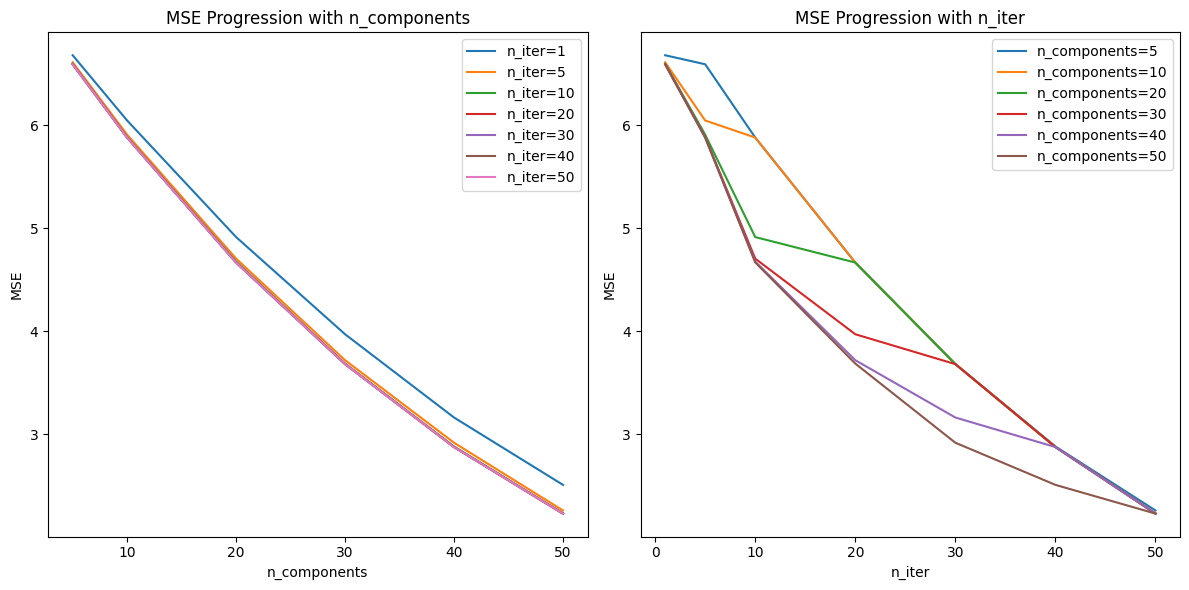

In [80]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Plot for n_components
plt.subplot(1, 2, 1)
for i, n_iter in enumerate(param_grid['n_iter']):
    subset = results['MSE'][i::len(param_grid['n_iter'])]
    plt.plot(param_grid['n_components'], subset, label=f'n_iter={n_iter}')

plt.title('MSE Progression with n_components')
plt.xlabel('n_components')
plt.ylabel('MSE')
plt.legend()

# Plot for n_iter
plt.subplot(1, 2, 2)
for i, n_components in enumerate(param_grid['n_components']):
    subset = results['MSE'][i::len(param_grid['n_components'])]
    plt.plot(param_grid['n_iter'], subset, label=f'n_components={n_components}')

plt.title('MSE Progression with n_iter')
plt.xlabel('n_iter')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [81]:
n_latent_factors = best_params['n_components']
n_iter = best_params['n_iter']
evaluate_model_accuracy(n_latent_factors, n_iter)

{'MSE': 2.2271305455382593, 'RMSE': 1.4835630320943782}

As mentioned, hyperparameter tuning aims to find the combination of hyperparameter values that leads to the best performance for a machine learning model. In our case, the hyperparameters being tuned are `n_components` and `n_iter` for Truncated SVD (Singular Value Decomposition).

We have a better output of `{'MSE': 2.2271305455382593, 'RMSE': 1.4835630320943782}`. The improved MSE value of 2.22 and RMSE value of 1.48 indicates that the predictive ratings deviate from the true ratings by a smaller unit of MSE=2.22 and RMSE=1.48, an improvement from the previous deviation of MSE=5.89 and RMSE=2.42.

This is due to the fact that we now have optimal values of `n_components=50` and `n_iter=20`. This means that at these values, we have the best number of components retained after decomposition and we have the best number of iterations for the Truncated SVD. By finding better combinations of hyperparameters, the model is better equipped to make accurate predictions, resulting in a lower Mean Squared Error (MSE) and Root Mean Squared Error (RMSE).

Its important to note that if I used bigger values of `n_components` and `n_iter`, the MSE would reduce as the model fits closer to the data. Striking the balance between better computational efficiency and accuracy is very important. In this case, I chose better efficiency because even though this is a relatively small dataset, having very big values of `n_components` and `n_iter` took about 2 minutes to run, so even bigger datasets would take hours if not days..

In [82]:
predicted_ratings = calculate_predicted_ratings(user_item_matrix, n_latent_factors, n_iter)

# Get recommendations
print(f"Recommended Items for User {user_id_to_recommend}:")
recommended_items = model_based_recommend_items(user_item_matrix, user_id_to_recommend, predicted_ratings)

Recommended Items for User 1:
Restaurant name: Sabores Express
Restaurant cuisine: Pizza  
Restaurant price range: 1
Restaurant description: Sabores Express, a well-known dining spot in BuenosAires, offers a mix of fast-food dishes and international flavors.
Restaurant about: {"Service options": {"Kerbside pickup": true, "Delivery": true, "Takeaway": true, "Dine-in": true}, "Accessibility": {"Wheelchair-accessible car park": false}, "Offerings": {"Alcohol": true, "Wine": true}, "Dining options": {"Breakfast": true, "Lunch": true}, "Atmosphere": {"Casual": true, "Cosy": true}, "Planning": {"Accepts reservations": false}, "Payments": {"Credit cards": true}}
Restaurant rating: 4.1
Restaurant no of reviews: 223.0


Restaurant name: Cucina De Santo
Restaurant cuisine: Italian  
Restaurant price range: 0
Restaurant description:  Av. Alicia Moreau de Justo 1190, BuenosAires
 BuenosAires, Argentina
 Cucina De Santo is known for its Italian cuisine and features a modern and elegant setting with

In [83]:
# Calculating Precision @K
count = 0

for recommendation in recommended_items.index:
    recommended_restaurant = original_df[original_df['place_id'] == recommendation]
    if recommended_restaurant['rating'].values[0] >= 4 and recommended_restaurant['no_of_reviews'].values[0] >= 200 and recommended_restaurant['price_range'].values[0] <= 2:
        count += 1

model_based_precision_at_k = count/num_recommendations

print("Model Based Precision @K is", model_based_precision_at_k)

Model Based Precision @K is 0.6


Assuming I'm user 1, I want to go to a restaurant so I go on my recommender platform and I receive 5 recommendations above.

Relevance is defined as restaurants with a combination of high average rating (above a 4), high number of reviews (at least 200) and a relatively low price point (2 and below). Exceptions can be made if the number of reviews and the average rating are both very high.

Out of the 5 restaurants recommended, 3 are relevant.

In [84]:

# Use boolean indexing to filter the DataFrame

filtered_df = original_df[original_df['rating'] > 4]
filtered_df = filtered_df[filtered_df['no_of_reviews'] > 200]
filtered_df = filtered_df[filtered_df['price_range'] < 2]

# Now, filtered_df contains only relevant restaurants  
filtered_df.shape

model_based_recall_at_k = count/filtered_df.shape[0]
print("Model Based Recall @K is", model_based_recall_at_k)


Model Based Recall @K is 0.13636363636363635


As analysed earlier, there are 3 relevant restaurants out of the recommended 5.
Therefore recall@K is $\frac{3}{22}$.

Some advantages of this model-based CF restaurant recommender implementation are:

**Advantages of Model-Based Collaborative Filtering using SVD:**

1. **Improved Scalability:**
   - Model-based collaborative filtering using Singular Value Decomposition (SVD) is computationally more scalable than memory-based collaborative filtering, especially when dealing with large datasets. SVD allows for dimensionality reduction, making computations more efficient.

2. **Handles Sparse Data:**
   - SVD can effectively handle sparse data where not all users have rated all items. It fills in the missing values in the user-item matrix, providing predictions even for items a user has not interacted with.

3. **Global Patterns Extraction:**
   - SVD helps in extracting global patterns from the user-item interactions. It identifies latent features that contribute to user preferences and item characteristics, capturing underlying patterns in the data.

**Disadvantages of Model-Based Collaborative Filtering using SVD:**

1. **Cold Start Problem:**
   - SVD-based collaborative filtering can face challenges in handling new users or items with no or very few ratings. This is known as the cold start problem, and SVD may struggle to provide accurate recommendations in such cases.

2. **Computationally Intensive Training:**
   - The training process for SVD models, particularly in large datasets, can be computationally intensive. This might be a limitation in real-time recommendation systems, where low-latency responses are crucial.

**Improvements over User-Based and Content-Based Approaches:**

1. **Overcoming Sparsity:**
   - Model-based collaborative filtering using SVD overcomes the sparsity issue better than user-based collaborative filtering. SVD fills in missing values in the user-item matrix, allowing for more reliable predictions. However, extremely sparse datasets may still pose challenges. In cases where there are very few ratings per user, the model may not be able to reliably capture user preferences.

2. **Handling New Users and Items:**
   - SVD can handle the cold start problem better than user-based collaborative filtering. It doesn't solely rely on user similarities, making it more adaptable to new users or items.

## **Comparative Analysis of the Implemented Systems**<a id="comparative-analysis-of-the-implemented-systems"></a>

So far, we have implemented the following 4 restaurant recommendation systems:
- Content-Based Method (from previous Assignment)
- Collaborative Filter Method
    - Memory-Based Method
        - User-Based Method
        - Item-Based Method
    - Model-Based Method using SVD

We will compare how accurate these methods are and the relevance of the restaurants they recommend.

**Content-based recommendation** is a type of personalized recommendation system that suggests items to users based on the characteristics and features of the items themselves, as well as the user's preferences and historical interactions. In our content-based recommendation systems, restaurants are described by a set of features, and recommendations are made by comparing the features of the restaurants to the user's preferences.

First, here is a recap of the Content-Based Method:

**1. Normalization:**
Normalization is a crucial step to ensure that numerical features like ratings and the number of reviews are on a consistent scale. By scaling these values between 0 and 1, we create a uniform baseline for analysis, preventing any particular feature from dominating others.

**2. Text Summarization using TF-IDF:**
The system converts restaurant descriptions into numerical scores using TF-IDF (Term Frequency-Inverse Document Frequency). This technique evaluates the importance of words in a document relative to a collection of documents. The average TF-IDF score for each restaurant's description provides a numerical representation of the overall significance of words.

**3. One-Hot Encoding:**
To handle categorical data, such as cuisine types, we employ one-hot encoding. This transforms categorical features into a numerical format, creating binary columns for each category. This numerical representation is essential for machine learning models that require input in numeric form.

**4. Data Processing:**
This step involves cleaning the dataset by removing redundant columns and filling missing values with zeros. This ensures a consistent and organized dataset for subsequent analysis and modeling.

**5. Cosine Similarity:**
Cosine similarity is employed to measure the similarity between the user profile and each restaurant in the dataset. This metric calculates the cosine of the angle between two non-zero vectors, providing a numerical indication of similarity. Higher cosine similarity scores signify greater similarity between user preferences and restaurant characteristics.

**6. Recommendation Generation:**
The final step is generating personalized restaurant recommendations. This process involves selecting a restaurant as a basis, determining its cuisine type, and then generating recommendations based on cuisine similarity and diversity criteria. The goal is to offer users suggestions that align with their preferences while introducing variety to enhance their overall experience.


In [85]:
import pandas as pd
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer


df = content_based_df.copy()
df_copy = df.copy()

def normalize(data):
    """
    Normalize a list of values to be between 0 and 1.
    
    Parameters:
        data (List) : The list of values you want to normalize
    
    Returns:
        The input data normalized between 0 and 1
    
    Source: (Vatsal, 2021)
    """
    # Find the minimum value in the data
    min_value = min(data)

    # If the minimum value is negative, shift all values to make them 
    # positive
    if min_value < 0:
        data = [x + abs(min_value) for x in data]
    
    # Find the maximum value in the data
    max_value = max(data)

    # Normalize the data to be between 0 and 1
    return [x / max_value for x in data]


# Normalize the 'rating' and number of reviews columns
df['rating_normalized'] = normalize(df['rating']
                                        .values)
df['no_of_reviews_normalized'] = normalize(df['no_of_reviews']
                                                .values)

def text_summarisation(df):

    # Fill NaN values in 'description' column with an empty string
    df['description'] = df['description'].fillna('')

    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the restaurant descriptions
    tfidf_matrix = vectorizer.fit_transform(df['description'])

    # Calculate the average TF-IDF score for each restaurant 
    # description
    average_tfidf_scores = tfidf_matrix.mean(axis=1)

    # Add the average TF-IDF scores to the DataFrame
    return average_tfidf_scores

# Now, our DataFrame 'df' contains a column 'description_score' 
# with numerical values representing the restaurant descriptions.
df['description_score']  = text_summarisation(df)

def one_hot_encode_and_append(df, column_name):
    '''
    This function performs one-hot encoding 
    on a specified column and appends it back to the dataframe.
    
    One-hot encodes the specified categorical column 
    and appends it to the input dataframe.

    One-hot encoding transforms categorical variables 
    into numerical format before
    fitting and training machine learning models.

    Parameters:
        df (DataFrame): The dataframe to which 
        the one-hot encoded columns will be appended.

        column_name (String): The name of the 
        column to be one-hot encoded.

    Returns:
        The dataframe with the one-hot encoded columns appended.
    '''

    # Perform one-hot encoding on the specified column
    one_hot_encoded_df = pd.get_dummies(df[column_name],dtype='int64')

    # Reset the index of the one-hot encoded DataFrame
    one_hot_encoded_df.reset_index(drop=True, inplace=True)

    # Concatenate the one-hot encoded DataFrame with the original DataFrame
    return pd.concat([df, one_hot_encoded_df], axis=1)


# One-hot encode 'type', 'price range'
df = one_hot_encode_and_append(df, column_name='cuisine')

# drop redundant columns
cols = [
'name','cuisine','rating','no_of_reviews','about',
'description','place_id'
    ]
df.drop(columns = cols, inplace = True)

# Filter the DataFrame based on the desired user_id
user_profile = df.loc[df['user_id'] == 1]
# Fill missing values with 0

# user_profile dataframe
user_profile = user_profile.fillna(0)

# original comprehensive dataframe
df = df.fillna(0)
similarity_scores = cosine_similarity(user_profile, df)

# Create a DataFrame to store similarity scores for each restaurant
similarity_df = pd.DataFrame(similarity_scores, columns=df.index)

# Transpose the DataFrame for easy sorting and ranking
# so each column is a restaurant on person_1's profile 
# and we get how similar it is to each restaurant in the dataset
similarity_df = similarity_df.transpose()

def choose_restaurant(choice_index, similarity_df):
    """
    Choose a restaurant as the basis for generating recommendations.

    Parameters:
    choice_index (int): The index of the restaurant to
    base recommendations on.

    similarity_df (pd.DataFrame): A DataFrame containing similarity 
    scores between restaurants and user preferences.

    Returns:
    pd.DataFrame: A sorted DataFrame with restaurants ranked by their 
    similarity to the chosen restaurant.

    This function takes a restaurant index and a similarity DataFrame 
    as input and sorts the restaurants in the DataFrame by their 
    similarity score to the chosen restaurant. The result is a 
    DataFrame where restaurants are ranked by their similarity to 
    the chosen restaurant, with the most similar restaurants at the 
    top.

    Example:
    >>> recommendations = choose_restaurant(5, similarity_df)
    """
    # Sort restaurants by similarity score for this user
    similarity_df = similarity_df.sort_values(by=choice_index, 
                                            ascending=False)
    
def determine_cuisine(choice_index):
    """
    Determine the cuisine type based on a chosen restaurant.

    Parameters:
    choice_index (int): The index of the restaurant used to 
        determine the cuisine.

    Returns:
    str: The cuisine type of the chosen restaurant.

    This function calculates the cuisine type based on 
        a chosen restaurant's index.
    It adjusts the index and extracts the cuisine type 
        from the DataFrame. The cuisine
    type is then printed as a craving and returned.

    Example:
    >>> cuisine = determine_cuisine(5)
    >>> print(f"I'm craving {cuisine}")
    I'm craving Italian
    """
    # Adjust the choice index
    choice_index = 142 + choice_index - 2

    # Get the cuisine type of the chosen restaurant
    cuisine_type = df_copy.iloc[choice_index]['cuisine']

    # Print the craving and return the cuisine type
    print(f"I'm craving {cuisine_type}")
    print('\n')
    return cuisine_type

def cuisine_recommendations(cuisine_type, total_no_of_recommendations, 
                            recommended_list):
    """
    Generate restaurant recommendations based on cuisine similarity.

    This function takes a cuisine type, 
        the total number of recommendations desired, 
        and a list of recommended restaurants.
    It finds restaurants of the specified cuisine in 
        the most similar restaurant list.

    Args:
    - cuisine_type (str): The target cuisine type.
    - total_no_of_recommendations (int): Total 
        number of recommendations needed.
    - recommended_list (list): A list to store 
        the recommended restaurant indices.

    Returns:
    - recommended_list (list): A list of recommended restaurant indices.
    - count (int): The number of recommendations found.
    """
    # Calculate the number of recommendations for the same cuisine
    similar_cuisine_recs = math.ceil(total_no_of_recommendations / 2) 

    # Get the index of the top similar restaurants
    top_restaurants = similarity_df.index
    count = 0

    # Iterate through the top restaurants and check their cuisine
    for restaurant_index in top_restaurants:

        # Access the cuisine of the restaurant from 
        # the original DataFrame
        cuisine = df.iloc[restaurant_index] 

        # Check if the restaurant has the specific cuisine 
        # (assuming the cuisine column is a boolean)
        # Check the restaurant hasn't been reviewed by user
        # indices less than 141 haven't been reviewed by user
        if cuisine[cuisine_type] == 1 and restaurant_index < 141:
            recommended_list.append(restaurant_index)
            count += 1

            # Break the loop if we have reached the desired 
            # number of similar cuisine recommendations
            if count >= similar_cuisine_recs:
                break

    return recommended_list, count

def diverse_recommendations(cuisine_type, total_no_of_recommendations, 
                            recommended_list, count):
    """
    Generate diverse restaurant recommendations.

    This function takes a cuisine type, 
        the total number of recommendations desired, 
        a list of recommended restaurants, and a count.
    It finds restaurants of different cuisines that 
        haven't been reviewed by the user from the most
        similar restaurant list.

    Args:
    - cuisine_type (str): The target cuisine type.
    - total_no_of_recommendations (int): 
        Total number of recommendations needed.
    - recommended_list (list): 
        A list to store the recommended restaurant indices.
    - count (int): The number of recommendations found so far.

    Returns:
    - recommended_list (list): A list of recommended restaurant indices.
    """
    # Get the index of the top similar restaurants
    diverse_recs = similarity_df.index 

    # Iterate through the top restaurants and check their cuisine
    for restaurant_index in diverse_recs:
        # Access the cuisine of the restaurant from 
        # the original DataFrame
        cuisine = df.iloc[restaurant_index]

        # Check if the restaurant has a different cuisine 
        # (assuming the cuisine column is a boolean)
        # Check the restaurant hasn't been reviewed by the user 
        # (indices less than 141 haven't been reviewed)
        if cuisine[cuisine_type] != 1 and restaurant_index < 141:
            recommended_list.append(restaurant_index)
            count += 1

            # Break the loop if we have reached the desired number of 
            # diverse recommendations
            if count >= total_no_of_recommendations:
                break

    return recommended_list

def get_recommendations(choice_index, total_no_of_recommendations):
    """
    Get restaurant recommendations based on choice and cuisine.

    This function takes a choice index and the total number of 
        recommendations desired. 
        It selects a restaurant, determines its cuisine, 
        and then generates a list of recommendations 
        based on that cuisine and diversity criteria.

    Args:
    - choice_index (int): The index of the chosen restaurant.
    
    - total_no_of_recommendations (int): Total number of 
        recommendations needed.

    Returns:
    None
    """
    # Choose a restaurant and sort the dataframe
    choose_restaurant(choice_index, similarity_df)

    # Determine the cuisine type of the chosen restaurant
    cuisine_type = determine_cuisine(choice_index)

    # initialise list to append indices of recommended restaurants
    recommended_list = []
    recommended_list, count = cuisine_recommendations(cuisine_type,
                total_no_of_recommendations, recommended_list)
    recommended_list = diverse_recommendations(cuisine_type, 
                total_no_of_recommendations, recommended_list, count)
    
    # Iterate through the recommended list 
    # and print details of each restaurant
    for r in range(len(recommended_list)):
        restaurant = df_copy.iloc[recommended_list[r]]
        print(f'Recommendation {r+1}:')
        print(f'Name: {restaurant["name"]}')
        print(f'Cuisine: {restaurant["cuisine"]}')
        print(f'Price Range: {restaurant["price_range"]}')
        print(f'Rating: {restaurant["rating"]}')
        print(f'Number of Reviews: {restaurant["no_of_reviews"]}')
        print(f'Description: {restaurant["description"]}\n')
    
    return recommended_list
        
choice_index = 37
total_no_of_recommendations = 5
content_based_recommendations = get_recommendations(choice_index,total_no_of_recommendations)

I'm craving Peruvian  


Recommendation 1:
Name: Coya
Cuisine: Peruvian  
Price Range: 2
Rating: 3.9
Number of Reviews: 526.0
Description:  Av. Alicia Moreau de Justo 134, BuenosAires
 BuenosAires, Argentina
 Coya is a fine dining restaurant with a focus on Peruvian cuisine, known for its fusion of flavors and stunning riverside location.

Recommendation 2:
Name: Restaurante Rawa
Cuisine: Peruvian  
Price Range: 2
Rating: 4.1
Number of Reviews: 1216.0
Description: Av. Cerviño 4602, BuenosAires, Argentina - A contemporary restaurant with a focus on seafood and international cuisine, offering a fresh and modern dining experience.

Recommendation 3:
Name: Bar Roman
Cuisine: Peruvian  
Price Range: 1
Rating: 4.1
Number of Reviews: 341.0
Description: Bar Roman, though not providing a specific address, is known for its inviting ambiance and culinary delights.

Recommendation 4:
Name: Elena
Cuisine: South American  
Price Range: 4
Rating: 4.6
Number of Reviews: 2323.0
Description: offers dine

In [86]:
# Calculating Precision @K
count = 0

for recommendation in content_based_recommendations:
    recommended_restaurant = original_df[original_df['place_id'] == recommendation+1]
    if recommended_restaurant['rating'].values[0] >= 4 and recommended_restaurant['no_of_reviews'].values[0] >= 200 and recommended_restaurant['price_range'].values[0] <= 2:
        count += 1

content_based_precision_at_k = count/num_recommendations
print("Content Based Precision @K is", content_based_precision_at_k)

# Use boolean indexing to filter the DataFrame

filtered_df = original_df[original_df['rating'] > 4]
filtered_df = filtered_df[filtered_df['no_of_reviews'] > 200]
filtered_df = filtered_df[filtered_df['price_range'] < 2]

# Now, filtered_df contains only relevant restaurants  
print("\nThe number of relevant restaurants are ", filtered_df.shape[0])

content_based_recall_at_k = count/filtered_df.shape[0]
print("Content Based Recall @K is", content_based_recall_at_k)

Content Based Precision @K is 0.4

The number of relevant restaurants are  22
Content Based Recall @K is 0.09090909090909091


Assuming I'm user 1, I want to go to a restaurant so I go on my recommender platform and I receive 5 recommendations above.

Relevance is defined as restaurants with a combination of high average rating (above a 4), high number of reviews (at least 200) and a relatively low price point (2 and below). Exceptions can be made if the number of reviews and the average rating are both very high.

Out of the 5 restaurants recommended, 2 are relevant.

As analysed earlier, there are 2 relevant restaurants out of the total 22.
Therefore recall@K is $\frac{2}{22}$.

In [87]:
# Collaborative Filtering
# User Based
print("User Based Mean Absolute Error", mae_user_based)
print("User Based Root Mean Squared Error", rmse_user_based)
print("\n")

# Item Based
print("Item Based Mean Absolute Error", mae_item_based)
print("Item Based Root Mean Squared Error", rmse_item_based)
print("\n")

# Model Based
print("Model Based Mean Squared Error", model_based_mse)
print("Model Based Root Mean Squared Error", model_based_rmse)

print("\n")
print("\n")

# Content Based
print("Content Based Precision @K is", content_based_precision_at_k)
print("Content Based Recall @K is", content_based_recall_at_k)
print("\n")

# Collaborative Filtering
# User Based
print("User Based Precision @K is", user_based_precision_at_k)
print("User Based Recall @K is", user_based_recall_at_k)
print("\n")

# Model Based
print("Model Based Precision @K is", model_based_precision_at_k)
print("Model Based Recall @K is", model_based_recall_at_k)




User Based Mean Absolute Error 0.11010970907468694
User Based Root Mean Squared Error 0.36966540887196425


Item Based Mean Absolute Error 0.10016742753952262
Item Based Root Mean Squared Error 0.2742625844434078


Model Based Mean Squared Error 5.885337294729468
Model Based Root Mean Squared Error 2.418612224862504




Content Based Precision @K is 0.4
Content Based Recall @K is 0.09090909090909091


User Based Precision @K is 0.4
User Based Recall @K is 0.09090909090909091


Model Based Precision @K is 0.6
Model Based Recall @K is 0.13636363636363635


**Mean Squared Error**

Model-Based Collaborative Filtering appears to have higher errors compared to the User-Based and Item-Based approaches. Lower values for MAE and RMSE in user-based and item-based approaches suggest that these models provide more accurate predictions in terms of rating values. Higher values for Model-Based Collaborative Filtering might indicate that while the precision and recall are higher, the predicted ratings are farther from the actual ratings. This may be because if the user-item interaction matrix is sparse (many missing values), it may be challenging for the model to accurately capture underlying patterns. User-Based and Item-Based methods might be less affected by sparsity as they focus on local neighborhoods of users or items.

**Precision & Recall**

The higher precision for the model-based approach suggests that it might be providing more accurate and targeted recommendations.
The higher recall for the model-based approach indicates that it's capturing a larger portion of all relevant items, making it more effective in terms of coverage. Regardless of whether we prioritise recall or precision, the **Model-Based Collaborative Filtering** approach is performing better with a precision of 0.6 and also has the highest recall at 0.136, indicating it captures a larger portion of relevant items.

Considering the financial constraints of college students, striking a balance between precision, recall and mse is key to delivering a recommender system that aligns with their preferences, budget, and overall satisfaction. Precision is important to avoid recommending restaurants that may strain the budget of broke college students. Recall is crucial to provide a diverse set of budget-friendly options, ensuring that students don't miss out on affordable hidden gems. Minimizing MSE ensures that the predicted satisfaction scores closely match the actual satisfaction scores, leading to more accurate recommendations tailored to individual preferences.

Personally, I would go for the the **Model-Based Collaborative Filtering** approach. Even though the predicted ratings vary by a relatively big number, the higher precision and recall is much more valuable to my wallet.

In [88]:
predicted_ratings = calculate_predicted_ratings(user_item_matrix, n_latent_factors, n_iter)

# Get recommendations
print(f"Recommended Items for User {user_id_to_recommend}:")
recommended_items = model_based_recommend_items(user_item_matrix, user_id_to_recommend, predicted_ratings)

Recommended Items for User 1:
Restaurant name: Sabores Express
Restaurant cuisine: Pizza  
Restaurant price range: 1
Restaurant description: Sabores Express, a well-known dining spot in BuenosAires, offers a mix of fast-food dishes and international flavors.
Restaurant about: {"Service options": {"Kerbside pickup": true, "Delivery": true, "Takeaway": true, "Dine-in": true}, "Accessibility": {"Wheelchair-accessible car park": false}, "Offerings": {"Alcohol": true, "Wine": true}, "Dining options": {"Breakfast": true, "Lunch": true}, "Atmosphere": {"Casual": true, "Cosy": true}, "Planning": {"Accepts reservations": false}, "Payments": {"Credit cards": true}}
Restaurant rating: 4.1
Restaurant no of reviews: 223.0


Restaurant name: La Tri restaurante ecutoriano
Restaurant cuisine: Ecuadorian
Restaurant price range: 0
Restaurant description: La Tri Restaurante Ecuatoriano, recognized in BuenosAires, offers a taste of Ecuadorian cuisine and flavors.
Restaurant about: {"Service options": {"Ke

I decided to try La Tri restaurante ecutoriano. Even though its not a relevant recommendation, seeing as it has very few reviews, I'm in South America so I figured I could try Ecuadorian cuisine. It was very good so even though this system is not specific to my preferences, it was still a delight that I enjoyed the food!

## **Executive Summary** <a id="executive-summary"></a>

**Data Collection:**

In the process of collecting and enhancing the dataset for the restaurant recommendation system, several challenges were encountered. The primary issues included insufficient data on restaurant reviews, difficulty in obtaining user opinions due to time constraints, and a lack of data engineering systems for managing extensive datasets required for building a robust recommendation system.

To address these challenges, a decision was made to generate synthetic data, focusing on random individuals providing reviews of restaurants in Buenos Aires. This approach transformed the recommendation system into a proof of concept, making it non-specific to any individual's preferences. Randomizing the number of reviews for each user aimed to simulate a spectrum of user engagement, from those interacting with numerous items to those with relatively fewer interactions.

**User-Based Collaborative Filtering:**
This method leverages the preferences and behaviors of similar users to make personalized recommendations for a target user. It involves creating a user-item matrix, computing user similarity with rating normalization, and predicting ratings based on the ratings of similar users. The recommendations are then generated for the target user.

**Item-Based Collaborative Filtering:**
Similar to User-Based CF, Item-Based CF utilizes user interactions and preferences. It involves creating a user-item matrix, computing item similarity with rating normalization, predicting ratings based on the ratings of similar items, and generating recommendations for the target user.

**Model-Based Collaborative Filtering:**
This method builds a predictive model using Singular Value Decomposition (SVD) for dimensionality reduction. It involves normalizing ratings, decomposing the user-restaurant matrix, and optimizing hyperparameters through a grid search. The recommended items are then generated based on the predicted ratings.

**Comparative Analysis:**
The implemented systems are compared, including Content-Based, User-Based CF, Item-Based CF, and Model-Based CF. Evaluation metrics such as Mean Squared Error (MSE), Precision, and Recall are utilized to assess the accuracy and relevance of recommendations.

**Content-Based Method:**
Recapitulating the Content-Based Method, it involves normalization, text summarization using TF-IDF, one-hot encoding, data processing, cosine similarity, and recommendation generation. The method focuses on describing restaurants by features and providing recommendations based on user preferences and restaurant characteristics.

**Model Comparison:**
The comparative analysis reveals that Model-Based Collaborative Filtering outperforms other methods in terms of precision, recall, and a balance between Mean Squared Error. Despite higher predicted rating variability, the model exhibits better accuracy and coverage, making it the preferred choice.

## **References**


Bhattacharyya, M. (2022, December 7). Metrics of Recommender Systems. Medium. https://towardsdatascience.com/metrics-of-recommender-systems-cde64042127a#:~:text=Spearman%20Coefficient&text=It%20is%20a%20correlation%20of<br>

AI Tools I used ChatGPT to:
Generate code to generate the dataset
Get Latex formatting for mathematical formulae
Put comments and docstrings in functions
Get simpler explanations on new concepts -- SVD
